# OzStar Results Cygnus X-1 Analysis Code 1.0e5 Yr
## 06/06/24
## Spencer Collaviti

In [1]:
# Import requisite libraries
import numpy as np
import matplotlib.pyplot as plt
import Config as conf
import sys
sys.path.append("../../SimulationCode")
import BaryakhtarFunctions as func
import copy
import superrad as sr
import superrad.harmonics as har
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import os.path
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

In [2]:
def interpolate(list1, list2, x):
    check = True
    i = 0
    if x < min(list1):
        return np.nan
    elif x > max(list1):
        return np.nan
    while check:
        if x <= list1[i]:
            check = False
            i -= 1
            return (list2[i] + ((list2[i+1]-list2[i])/(list1[i+1]-list1[i]))*(x-list1[i]))
        i += 1
        if i >= len(list1):
            check = False
            return np.nan
        
def lin_fit(x1,y1,x2,y2,x):
    return y1 + ((y2-y1)/(x2-x1))*(x-x1)
        
def find_match_index(x,x_list):
    if x < min(x_list):
        return 0
    elif x > max(x_list):
        return -1
    else:
        i = 0
        for j in range(len(x_list)):
            if x_list[j] <= x:
                i = j
        return i
    
def tick_function(X):
    return ["%.2f" % z for z in X]

In [3]:
# Define constants
h = 6.6260715e-34
c = 299792458
e = 1.60217663e-19

# Define parameters
age = 1.0e5
bhmi = 14.8
bhmf_goal = 14.8
bhsi = 0.99
d = 6.9063e19 # Distance to Cygnus X-1 in metres
iota = 27.1*(2*np.pi/360) # Inclination angle
save = True # Whether to save plots
save_folder = "../OutputPlots/" # Where to save plots


# Define folder of main results
folder = "ResultsCyg1e5/"

out_path = folder+"out.txt"
ngoal1_path = folder+"ngoal1.txt"
ngoal2_path = folder+"ngoal2.txt"
there_path = folder+"there.txt"
drift_path = folder+"drift.txt"

# Define paths to bounds
bound_211_path = "211bounds.txt"

# Generate meshgrids to store data
# Arrays for varying parameters
n_variations_bm = conf.n_variations_bm
n_variations_f = conf.n_variations_f
bm_vals = np.linspace(conf.bm_min,conf.bm_max,num = n_variations_bm)
f_vals = np.logspace(conf.log10_f_min,conf.log10_f_max,num = n_variations_f)
# Generate meshgrids
bm_V, f_V = np.meshgrid(bm_vals,f_vals)
bhmi_V = np.zeros_like(bm_V)*np.nan
bhm_V = np.zeros_like(bm_V)*np.nan
bhs_V = np.zeros_like(bm_V)*np.nan
e_211_V = np.zeros_like(bm_V)*np.nan
e_322_V = np.zeros_like(bm_V)*np.nan
drift_211_211_an_V = np.zeros_like(bm_V)*np.nan
drift_322_322_an_V = np.zeros_like(bm_V)*np.nan
drift_322_to_211_V = np.zeros_like(bm_V)*np.nan

### Read in Main Regime Data

In [4]:
# Determine param numbers
all_param_numbers = []
for j in range(n_variations_f):
    for i in range(n_variations_bm):
        all_param_numbers.append(str(j)+"X"+str(i))

file = open(there_path,"r")
line = file.readline()
there_param_numbers = [x for x in line.split(",")]
file.close()

try:
    file = open(ngoal1_path,"r")
    line = file.readline()
    ngoal1_param_numbers = [x for x in line.split(",")]
    file.close()
except:
    ngoal1_param_numbers = []

try:
    file = open(ngoal2_path,"r")
    line = file.readline()
    ngoal2_param_numbers = [x for x in line.split(",")]
    file.close()
except:
    ngoal2_param_numbers = []

missing_param_numbers = list(set(all_param_numbers)-set(there_param_numbers))
print(len(ngoal1_param_numbers))

0


In [5]:
# Read in the main data
shift = 5 # Shift of data from parameters
file = open(out_path,"r")
for param_id in there_param_numbers:
    if False: #param_id in ngoal2_param_numbers and param_id in ngoal1_param_numbers:
        file.readline()
    else:
        coord1, coord2 = param_id.split("X")
        coord1 = int(coord1)
        coord2 = int(coord2)
        line = file.readline().rstrip()
        line_split = line.split(",")
        bhmi_V[coord1,coord2] = np.float64(line_split[0])
        bhm_V[coord1,coord2] = np.float64(line_split[shift])
        bhs_V[coord1,coord2] = np.float64(line_split[shift+1])
        e_211_V[coord1,coord2] = np.float64(line_split[shift+2])
        e_322_V[coord1,coord2] = np.float64(line_split[shift+3])
file.close()

# Force e_211_V and e_322_V to be positive
e_211_V[~np.logical_or(e_211_V>0,np.isnan(e_211_V))] = 0.0
e_322_V[~np.logical_or(e_322_V>0,np.isnan(e_322_V))] = 0.0

In [6]:
# Read in the drift data
file = open(drift_path,"r")
for param_id in there_param_numbers:
    if param_id in ngoal2_param_numbers and param_id in ngoal1_param_numbers:
        file.readline()
    else:
        coord1, coord2 = param_id.split("X")
        coord1 = int(coord1)
        coord2 = int(coord2)
        line = file.readline().rstrip()
        line_split = line.split(",")
        o_omega_211 = np.float64(line_split[0])
        omega_211 = np.float64(line_split[1])
        o_omega_322 = np.float64(line_split[2])
        omega_322 = np.float64(line_split[3])
        D_t = np.float64(line_split[4])*(func.secinh*func.hinyr)
        drift_211_211_an_V[coord1,coord2] = 2*(omega_211-o_omega_211)/(D_t*2*np.pi)
        drift_322_322_an_V[coord1,coord2] = 2*(omega_322-o_omega_322)/(D_t*2*np.pi)
        drift_322_to_211_V[coord1,coord2] = (omega_211+omega_322-o_omega_211-o_omega_322)/(D_t*2*np.pi)
file.close()

### Generate Regime Boundaries

In [7]:
secinh = 3600
hinyr = 8766

# Define array to store category
cat_V = np.zeros_like(bm_V,dtype=int)

# Assign values for computations
e_211 = 1.0
e_322 = 1.0
bhs = bhsi
bhm = bhmi

# Precompute factors
unit_factor = 4.920551932748678e-06 * bhm / (secinh*hinyr)  # Unit factor for t in yr
mass_factor = func.G*(bhm*func.M_sol)**2/(func.hbar*func.c)
r_tilda = 1+(1-bhs**2)**(1/2)

# Read in SI corrections
interpolator = func.make_SI_rate_correction_interpolator(conf.rc_SI_data_path)

# Generate SR object
rel_cloud_model = sr.rel_sca_cloud.RelScalar()

for j in range(len(f_V[0])):
    # Read out the boson mass and compute alpha
    bm = bm_V[0,j]
    alpha = func.compute_alpha(bm,bhm)
    # Compute unit correction factor dependent on boson mass
    unit_factor_2 = 3.6283745e52 * (secinh*hinyr) * func.G/(func.hbar*func.c) *bhm**4 * (bm*func.e/(func.c**2))**2 # Unit factor for P in J / yr
    for i in range(len(f_V)):
        f = f_V[i,j]
        # Compute the rates of the various processes
        rate_consts = func.compute_rate_constants(bm, f)
        # First, lowest-order rates
        rate_211_SR, rate_322_SR, rate_211_to_322, rate_322_to_211, rate_211_211_an_GW, rate_211_322_an_GW,\
        rate_322_322_an_GW, rate_322_to_211_GW, rate_211_211_211_RE, rate_211_211_322_RE, rate_211_322_322_RE,\
        rate_322_322_322_RE  = func.compute_rates(bhm, bhs, e_211, e_322, bm, rate_consts, "Gravitational")
        # Then, higher order corrections
        rate_211_to_322 = rate_211_to_322*interpolator([bhs,alpha])[0]
        omega_i_211 = rel_cloud_model.omega_imag(1,alpha,bhs)
        omega_i_322 = rel_cloud_model.omega_imag(2,alpha,bhs)
        P_GW_211 = rel_cloud_model.power_gw(1, alpha, bhs)
        P_GW_322 = rel_cloud_model.power_gw(2, alpha, bhs)
        if not(np.isnan(omega_i_211)):
            rate_211_SR = (2*omega_i_211/(unit_factor))*e_211
        if not(np.isnan(omega_i_322)):
            rate_322_SR = (2*omega_i_322/(unit_factor))*e_322
        if not(np.isnan(P_GW_211)):
            rate_211_211_an_GW = (P_GW_211*unit_factor_2)/(2*func.compute_energy(bm,bhm,2)*bhm**4)*e_211**2
        if not(np.isnan(P_GW_322)):
            rate_322_322_an_GW = (P_GW_322*unit_factor_2)/(2*func.compute_energy(bm,bhm,3)*bhm**4)*e_322**2
            
        # Determine which regime the point is in
        e_211_max = (bhs - 4*alpha/((1+4*alpha**2)))
        if ((rate_211_to_322*e_211_max**2) > (np.log(mass_factor)/age)) and ((rate_211_to_322*e_211_max**2/np.log(mass_factor))>2*rate_211_211_an_GW*e_211_max):
            cat_V[i,j] = 1
        if ((rate_211_to_322*e_211_max**2) > (2*np.log(mass_factor)*rate_211_SR)) and ((f*1e9*func.e) < (func.M_pl*func.c**2*(np.sqrt(3)/2*(rate_211_to_322*e_211_max / (rate_211_SR*rate_322_to_211)**0.5))**0.5)):
            cat_V[i,j] = 2
        tau_sd = np.sqrt(3)/2*(rate_211_to_322)/((rate_322_to_211)**0.5*(rate_211_SR)**1.5)
        if tau_sd > age:
            cat_V[i,j] = 3

In [8]:
# Define lists to store values
bm_grav_mod_list = []
grav_mod_list = []
bm_mod_strong_list = []
mod_strong_list = []
bm_strong_very_strong_list = []
strong_very_strong_list = []

# Generate curves
for j in range(len(f_V[0])):
    for i in range(len(f_V)-1):
        if cat_V[i+1,j] < cat_V[i,j]:
            if cat_V[i,j] == 3:
                bm_strong_very_strong_list.append(bm_V[i,j])
                strong_very_strong_list.append((f_V[i,j]+f_V[i+1,j])/2)
            elif cat_V[i,j] == 2:
                bm_mod_strong_list.append(bm_V[i,j])
                mod_strong_list.append((f_V[i,j]+f_V[i+1,j])/2)
            elif cat_V[i,j] == 1:
                bm_grav_mod_list.append(bm_V[i,j])
                grav_mod_list.append((f_V[i,j]+f_V[i+1,j])/2)

# Remove repeated points
# Initialise to store points to be remove
grav_mod_pop_list = []
mod_strong_pop_list = []
strong_very_strong_pop_list = []
# Determine poins to be removed
for i in range(len(grav_mod_list)-1):
    if grav_mod_list[i] == grav_mod_list[i+1]:
        grav_mod_pop_list.append(i)
    if mod_strong_list[i] == mod_strong_list[i+1]:
        mod_strong_pop_list.append(i)
    if strong_very_strong_list[i] == strong_very_strong_list[i+1]:
        strong_very_strong_pop_list.append(i)
# Remove points
for i in range(len(grav_mod_pop_list)):
    if grav_mod_pop_list[-(i+1)] != len(grav_mod_list):
        bm_grav_mod_list.pop(grav_mod_pop_list[-(i+1)])
        grav_mod_list.pop(grav_mod_pop_list[-(i+1)])
for i in range(len(mod_strong_pop_list)):
    if mod_strong_pop_list[-(i+1)] != len(mod_strong_list):
        bm_mod_strong_list.pop(mod_strong_pop_list[-(i+1)])
        mod_strong_list.pop(mod_strong_pop_list[-(i+1)])
for i in range(len(strong_very_strong_pop_list)):
    if strong_very_strong_pop_list[-(i+1)] != len(strong_very_strong_list):
        bm_strong_very_strong_list.pop(strong_very_strong_pop_list[-(i+1)])
        strong_very_strong_list.pop(strong_very_strong_pop_list[-(i+1)])

In [9]:
# Convert to arrays
grav_mod_list = np.array(grav_mod_list,dtype="float")
bm_grav_mod_list = np.array(bm_grav_mod_list,dtype="float")
mod_strong_list = np.array(mod_strong_list,dtype="float")
bm_mod_strong_list = np.array(bm_mod_strong_list,dtype="float")
strong_very_strong_list = np.array(strong_very_strong_list,dtype="float")
bm_strong_very_strong_list = np.array(bm_strong_very_strong_list,dtype="float")

### Plot Cloud Condition

In [10]:
# Define alpha ticks
new_tick_alphas = np.array([0.05,0.10,0.15])#,0.20])
new_tick_locations = func.invert_alpha_bm(new_tick_alphas,bhmf_goal)

# Define colorbar ticks
my_ticks = [10**(-15),10**(-12.5),10**(-10),10**(-7.5),10**(-5),10**(-2.5),1]
my_tick_labels = [r"$10^{-15}$","","$10^{-10}$","","$10^{-5}$","","$10^{0}$"]

Text(0, 0.5, 'f/GeV')

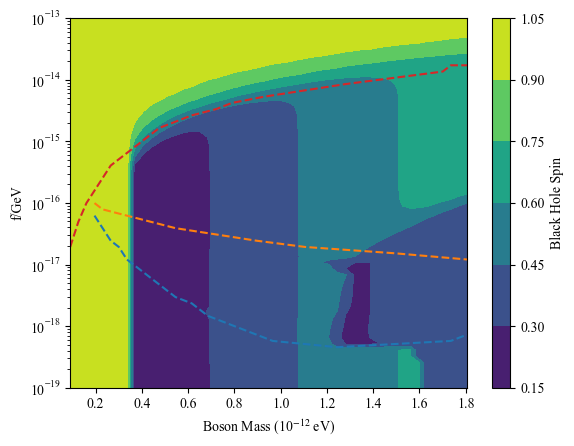

In [11]:
plt.contourf(bm_V*1e12,1/f_V,bhs_V)
plt.yscale('log')
plt.colorbar(label="Black Hole Spin")
plt.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
plt.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
plt.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
plt.xlabel("Boson Mass (10$^{-12}$ eV)")
plt.ylabel("f/GeV")

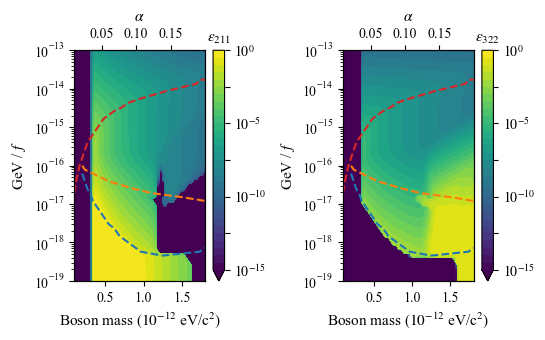

In [12]:
#Occupation Numbers
# Define ranges of log scales:
e_211_crange = np.logspace(-15,0,num=31)
e_322_crange = np.logspace(-15,0,num=31)
# Clean data of values outside of this range
e_211_c_V = np.copy(e_211_V)
e_322_c_V = np.copy(e_322_V)
for i in range(len(e_211_c_V)):
    for j in range(len(e_211_c_V[i])):
        if e_211_c_V[i][j]<1e-15:
            e_211_c_V[i][j]=1e-16
        if e_322_c_V[i][j]<1e-15:
            e_322_c_V[i][j]=1e-16
            
fig, (ax3, ax4) = plt.subplots(1,2,figsize=(6*(3.5/3.8),3.5))
ax3.set_yscale("log")
ax3.set_ylim(1e-19,1e-13)
ax3.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)", fontsize=11)
ax3.set_ylabel("GeV / $f$", fontsize=11)
plot3 = ax3.contourf(bm_V*1e12,1/f_V,e_211_c_V,e_211_crange,norm=LogNorm(),extend="min")
cbar = fig.colorbar(plot3,ax=ax3,ticks=my_ticks)
cbar.ax.set_title(r"$\varepsilon_{211}$", fontsize=11)
cbar.ax.set_yticklabels(my_tick_labels)
#ax3.plot(bm_vals*1e12,f_AB_vals,linestyle="--",label="A-B",color="C0")
#ax3.plot(bm_vals*1e12,f_BC_vals,linestyle="--",label="B-C",color="C1")
#ax3.plot(bm_vals*1e12,f_CD_vals,linestyle="--",label="C-D",color="C3")
ax3.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax3.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax3.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")

ax4.set_yscale("log")
ax4.set_ylim(1e-19,1e-13)
ax4.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)", fontsize=11)
ax4.set_ylabel("GeV / $f$", fontsize=11)
plot4 = ax4.contourf(bm_V*1e12,1/f_V,e_322_c_V,e_322_crange,norm=LogNorm(),extend="min")
cbar = fig.colorbar(plot4,ax=ax4,ticks=my_ticks)
cbar.ax.set_title(r"$\varepsilon_{322}$", fontsize=11)
cbar.ax.set_yticklabels(my_tick_labels)
ax4.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax4.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax4.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax4.plot(bm_vals*1e12,f_AB_vals,linestyle="--",label="A-B",color="C0")
#ax4.plot(bm_vals*1e12,f_BC_vals,linestyle="--",label="B-C",color="C1")
#ax4.plot(bm_vals*1e12,f_CD_vals,linestyle="--",label="C-D",color="C3")

# Set alpha ticks
ax7 = ax3.twiny()
ax8 = ax4.twiny()
ax7.set_xlim(ax3.get_xlim())
ax8.set_xlim(ax4.get_xlim())
ax7.set_xticks(new_tick_locations*1e12)
ax8.set_xticks(new_tick_locations*1e12)
ax7.set_xticklabels(tick_function(new_tick_alphas))
ax8.set_xticklabels(tick_function(new_tick_alphas))
ax7.set_xlabel(r"$\alpha$", fontsize=11)
ax8.set_xlabel(r"$\alpha$", fontsize=11)
plt.tight_layout()
#plt.savefig("NROccupations1e5.pdf",bbox_inches="tight")
plt.show()

### Determine Detection Boundaries Data

In [13]:
# Compute angular distribution correction factor

# For 211
def ang_211_power(N_211,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = 9*func.G*func.hbar**2/(2**26*func.c)
    scale = N_211**2*alpha**18/r_g**4
    angular_dependence = (35+28*np.cos(2*theta)+np.cos(4*theta))
    return const*scale*angular_dependence
# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
# Compute max vs. integral
ang_211_template = ang_211_power(1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_211_template)
max_v_auc_211 = max(ang_211_template)/auc
h_factor_211 = ((ang_211_power(1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

# For 322
Mc = 1.0
Mbh = 14.8
abh = 0.5
_m = 2
mu_fac = 7.48548859e9
_mu = 1e-13*mu_fac # eV by factor
d_fac = 4.78691895e-20
_d = 2.25e-3*d_fac
_cloud_model = sr.rel_sca_cloud.RelScalar()

thetaObs_array = np.linspace(0,1*np.pi,num=101)
hp_array = np.zeros_like(thetaObs_array)
hx_array = np.zeros_like(thetaObs_array)

for i, thetaObs in enumerate(thetaObs_array):
    strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
    hl = strain_vec(_m, _mu*Mbh, abh)
    
    hp = 0.0
    hx = 0.0
    l = 2*_m 
    for hl0 in hl:
        Yp = har.sYlm(-2,l,2*_m,thetaObs)
        Ym = har.sYlm(-2,l,-2*_m,thetaObs)
        hp = hp + hl0*(Yp+(-1)**l*Ym)
        hx = hx + hl0*(Yp-(-1)**l*Ym)
        l = l + 1
    delta = np.angle(hx)-np.angle(hp)
    #Make delta in [-pi,pi)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi
    hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
    hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)
    
    hp_array[i] = hp
    hx_array[i] = hx

auc = np.trapz(np.sin(thetaObs_array)*(hp_array**2+hx_array**2))

strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
hl = strain_vec(_m, _mu*Mbh, abh)

hp = 0.0
hx = 0.0
l = 2*_m 
for hl0 in hl:
    Yp = har.sYlm(-2,l,2*_m,iota)
    Ym = har.sYlm(-2,l,-2*_m,iota)
    hp = hp + hl0*(Yp+(-1)**l*Ym)
    hx = hx + hl0*(Yp-(-1)**l*Ym)
    l = l + 1
hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)
    
h_factor_322 = (((hp**2+hx**2)/auc)/max_v_auc_211)**0.5

# For transition
def ang_transition_power(N_211,N_322,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = func.G*func.hbar**2/(np.pi*func.c)
    scale = N_322*N_211*alpha**14/r_g**4
    angular_dependence = 2**5/(3**6*5**8)*(1-np.cos(theta)**4)+((27+28*np.cos(2*theta)+9*np.cos(4*theta))*np.sin(theta)**2)/\
    (2**2*3**6*5**10*7**2)
    return const*scale*angular_dependence

# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
ang_transition_template = ang_transition_power(1e76,1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_transition_template)
# Compute h factor function
h_factor_tr = ((ang_transition_power(1e76,1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

# Report results (rel. to h for face-on 211 annihilation signal)
print(h_factor_211)
print(h_factor_322)
print(h_factor_tr)

# Correct for definition from 211 annihilation at iota
h_factor_322 = h_factor_322/h_factor_211
h_factor_tr = h_factor_tr/h_factor_211
h_factor_211 = h_factor_211/h_factor_211

# Report results (For use)
print(h_factor_211)
print(h_factor_322)
print(h_factor_tr)

0.8932311943750108
0.32895530246157423
0.4312381847610747
1.0
0.36827565420142155
0.48278451030005715


In [14]:
# Read in sensitivity curves
sens_dict = func.read_in_sensitivity_curves("../SensitivityCurves/")
# Add extra curve for Lilli's PSD
sens_dict["o2_real"] = func.read_in_lilli_sensitivity_curves("../o2-psd-H1L1.txt")

# Read in detection bounds for O2 Search on Cygnus
ref_frequencies = [255.5, 355.5, 441.5, 573.5, 665.5, 735.5]
ref_h0_bounds = [3.9e-25, 4.8e-25, 5.7e-25, 7.2e-25, 8e-25, 8.8e-25]

In [15]:
# Define curves to find prospective sensitivity
curves_of_interest = ["o2","o2_real","aligo_design","ce2","et_d","decigo","magiss-r"]
# Define dictionary to store bounds
h0_211_bounds_dict = dict()
for curve in curves_of_interest:
    h0_211_bounds_dict[curve] = []
    for val in ref_frequencies:
        h0_211_bounds_dict[curve].append(np.zeros_like(sens_dict[curve][0]))
        
# Find prospective sensitivity for each curve
for curve in curves_of_interest:
    freq_list = sens_dict[curve][0]
    ASD_list = sens_dict[curve][1]
    for i in range(len(ref_frequencies)):
        ref_freq = ref_frequencies[i]
        ref_h0_bound = ref_h0_bounds[i]
        # Determine matching sensitivity from Lilli's O2 Sensitivity data
        j = find_match_index(ref_freq,sens_dict["o2_real"][0])
        ref_ASD = sens_dict["o2_real"][1][j]
        for k in range(len(freq_list)):
            freq = freq_list[k]
            ASD = ASD_list[k]
            # Scale and store value
            if curve == "o2_real":
                T_obs_scale = (233/233)
                h0_211_bounds_dict[curve][i][k] = ref_h0_bound*(freq/ref_freq)**(1/4)*(ASD/ref_ASD)*T_obs_scale**(-1/4)
            else:
                T_obs_scale = (365/233) # (233/80)**2
                h0_211_bounds_dict[curve][i][k] = ref_h0_bound*(ASD/ref_ASD)*T_obs_scale**(-1/4)*(2)**0.5
            

for curve in curves_of_interest:
    #val = np.zeros_like(h0_211_bounds_dict[curve][0])
    #count = 0
    #for i in range(len(h0_211_bounds_dict[curve])):
    #    val += h0_211_bounds_dict[curve][i]
    #    count += 1
    #val = val/count
    #h0_211_bounds_dict[curve] = val
    h0_211_bounds_dict[curve] = h0_211_bounds_dict[curve][0]

### Determine gravitational wave strength

In [16]:
# Define arrays to store strains
h_211_211_an_V = np.zeros_like(bm_V)*np.nan
h_322_322_an_V = np.zeros_like(bm_V)*np.nan
h_322_to_211_V = np.zeros_like(bm_V)*np.nan

# Define arrays to store frequencies
nu_211_an_V = np.zeros_like(bm_V)*np.nan
nu_322_an_V = np.zeros_like(bm_V)*np.nan
nu_tr_V = np.zeros_like(bm_V)*np.nan

# Define array to determine bound computation
h_211_fail_dict = {"o2_real":np.zeros_like(bm_V),"o2":np.zeros_like(bm_V),"aligo_design":np.zeros_like(bm_V),"ce2":np.zeros_like(bm_V),
                   "et_d":np.zeros_like(bm_V),"magiss-r":np.zeros_like(bm_V),"decigo":np.zeros_like(bm_V)}
h_322_fail_dict = {"o2_real":np.zeros_like(bm_V),"o2":np.zeros_like(bm_V),"aligo_design":np.zeros_like(bm_V),"ce2":np.zeros_like(bm_V),
                   "et_d":np.zeros_like(bm_V),"magiss-r":np.zeros_like(bm_V),"decigo":np.zeros_like(bm_V)}
h_tr_fail_dict = {"o2_real":np.zeros_like(bm_V),"o2":np.zeros_like(bm_V),"aligo_design":np.zeros_like(bm_V),"ce2":np.zeros_like(bm_V),
                  "et_d":np.zeros_like(bm_V),"magiss-r":np.zeros_like(bm_V),"decigo":np.zeros_like(bm_V)}

max_power = 0.0
# Compute strains
for i in range(len(e_211_c_V)):
    for j in range(len(e_211_c_V[i])):
            # Pull values
            bm = bm_V[i][j]
            bhm = bhm_V[i][j]
            f = f_V[i][j]
            e_211 = e_211_V[i][j]
            e_322 = e_322_V[i][j]
            # Compute alpha
            alpha = func.compute_alpha(bm, bhm)
            # Compute energies
            E_211_211_an = 2*func.compute_energy(bm, bhm, 2)
            E_322_322_an = 2*func.compute_energy(bm, bhm, 3)
            E_322_to_211 = func.compute_energy(bm, bhm, 3) - func.compute_energy(bm_V[i][j], bhm, 2)
            # Compute rate constants
            const_211_SR, const_322_SR, const_211_to_322, const_322_to_211, const_211_211_an_GW, const_211_322_an_GW,\
            const_322_322_an_GW, const_322_to_211_GW, const_211_211_211_RE, const_211_211_322_RE, const_211_322_322_RE,\
            const_322_322_322_RE = func.compute_rate_constants(bm,f)
            # Compute rates in epsilon
            ep_rate_211_211_an = func.compute_rate_211_211_an_GW(const_211_211_an_GW, alpha, e_211)
            ep_rate_322_322_an = func.compute_rate_322_322_an_GW(const_322_322_an_GW, alpha, e_322)
            ep_rate_322_to_211 = func.compute_rate_322_to_211_GW(const_322_to_211_GW, alpha, e_211, e_322)
            # Convert rates to N and from years^-1 to s^-1
            N_rate_211_211_an = func.convert_rates(ep_rate_211_211_an, bhm)
            N_rate_322_322_an = func.convert_rates(ep_rate_322_322_an, bhm)
            N_rate_322_to_211 = func.convert_rates(ep_rate_322_to_211, bhm)
            # Compute characteristic strains
            h_211_211_an_V[i][j] = func.compute_characteristic_strain(E_211_211_an, N_rate_211_211_an, d)
            h_322_322_an_V[i][j] = func.compute_characteristic_strain(E_322_322_an, N_rate_322_322_an, d)
            h_322_to_211_V[i][j] = func.compute_characteristic_strain(E_322_to_211, N_rate_322_to_211, d)
            # Compare characterstic strains to bounds
            nu_211_211_an = E_211_211_an/h
            nu_322_322_an = E_322_322_an/h
            nu_322_to_211 = E_322_to_211/h
            for curve in curves_of_interest:
                if interpolate(sens_dict[curve][0], h0_211_bounds_dict[curve], nu_211_211_an) <= h_factor_211*h_211_211_an_V[i][j]:
                    h_211_fail_dict[curve][i][j] = 1
                if interpolate(sens_dict[curve][0], h0_211_bounds_dict[curve], nu_322_322_an) <= h_factor_322*h_322_322_an_V[i][j]:
                    h_322_fail_dict[curve][i][j] = 1
                if interpolate(sens_dict[curve][0], h0_211_bounds_dict[curve], nu_322_to_211) <= h_factor_tr*h_322_to_211_V[i][j]:
                    if curve == "o2_real":
                        print(i,j, nu_322_to_211)
                    h_tr_fail_dict[curve][i][j] = 1
            nu_211_an_V[i,j]=nu_211_211_an
            nu_322_an_V[i,j]=nu_322_322_an
            nu_tr_V[i,j]=nu_322_to_211
            # Find max power
            if N_rate_211_211_an*E_211_211_an > max_power:
                max_power = N_rate_211_211_an*E_211_211_an
            if N_rate_322_322_an*E_322_322_an > max_power:
                max_power = N_rate_322_322_an*E_322_322_an
            if N_rate_322_to_211*E_322_to_211 > max_power:
                max_power = N_rate_322_to_211*E_322_to_211

In [17]:
# Generate minimum f values list for shading the excluded region
# Define max f to be used in case of failure of detection (this is a plotting thing without physical significance)
# Simply put, a big number must be chosen
max_f = 1e25
min_f_list = []
for i in range(len(f_V[0])):
    val = max_f
    for j in range(len(f_V)):
        if h_211_fail_dict["o2_real"][-j,i] == 1:
            val = f_V[-j,i]
    min_f_list.append(val)

### Plot Gravitational Wave Strength
#### Without Contours

In [18]:
# Compute angular distribution correction factor

# For 211
def ang_211_power(N_211,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = 9*func.G*func.hbar**2/(2**26*func.c)
    scale = N_211**2*alpha**18/r_g**4
    angular_dependence = (35+28*np.cos(2*theta)+np.cos(4*theta))
    return const*scale*angular_dependence
# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
# Compute max vs. integral
ang_211_template = ang_211_power(1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_211_template)
max_v_auc_211 = max(ang_211_template)/auc
h_factor_211 = ((ang_211_power(1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

# For 322
Mc = 1.0
Mbh = 14.8
abh = 0.5
_m = 2
mu_fac = 7.48548859e9
_mu = 1e-13*mu_fac # eV by factor
d_fac = 4.78691895e-20
_d = 2.25e-3*d_fac
_cloud_model = sr.rel_sca_cloud.RelScalar()

thetaObs_array = np.linspace(0,1*np.pi,num=101)
hp_array = np.zeros_like(thetaObs_array)
hx_array = np.zeros_like(thetaObs_array)

for i, thetaObs in enumerate(thetaObs_array):
    strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
    hl = strain_vec(_m, _mu*Mbh, abh)
    
    hp = 0.0
    hx = 0.0
    l = 2*_m 
    for hl0 in hl:
        Yp = har.sYlm(-2,l,2*_m,thetaObs)
        Ym = har.sYlm(-2,l,-2*_m,thetaObs)
        hp = hp + hl0*(Yp+(-1)**l*Ym)
        hx = hx + hl0*(Yp-(-1)**l*Ym)
        l = l + 1
    delta = np.angle(hx)-np.angle(hp)
    #Make delta in [-pi,pi)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi
    hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
    hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)
    
    hp_array[i] = hp
    hx_array[i] = hx

auc = np.trapz(np.sin(thetaObs_array)*(hp_array**2+hx_array**2))

strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
hl = strain_vec(_m, _mu*Mbh, abh)

hp = 0.0
hx = 0.0
l = 2*_m 
for hl0 in hl:
    Yp = har.sYlm(-2,l,2*_m,iota)
    Ym = har.sYlm(-2,l,-2*_m,iota)
    hp = hp + hl0*(Yp+(-1)**l*Ym)
    hx = hx + hl0*(Yp-(-1)**l*Ym)
    l = l + 1
hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)
    
h_factor_322 = (((hp**2+hx**2)/auc)/max_v_auc_211)**0.5

# For transition
def ang_transition_power(N_211,N_322,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = func.G*func.hbar**2/(np.pi*func.c)
    scale = N_322*N_211*alpha**14/r_g**4
    angular_dependence = 2**5/(3**6*5**8)*(1-np.cos(theta)**4)+((27+28*np.cos(2*theta)+9*np.cos(4*theta))*np.sin(theta)**2)/\
    (2**2*3**6*5**10*7**2)
    return const*scale*angular_dependence

# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
ang_transition_template = ang_transition_power(1e76,1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_transition_template)
# Compute h factor function
h_factor_tr = ((ang_transition_power(1e76,1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

# Report results (rel. to h for face-on 211 annihilation signal)
print(h_factor_211)
print(h_factor_322)
print(h_factor_tr)

0.8932311943750108
0.32895530246157423
0.4312381847610747


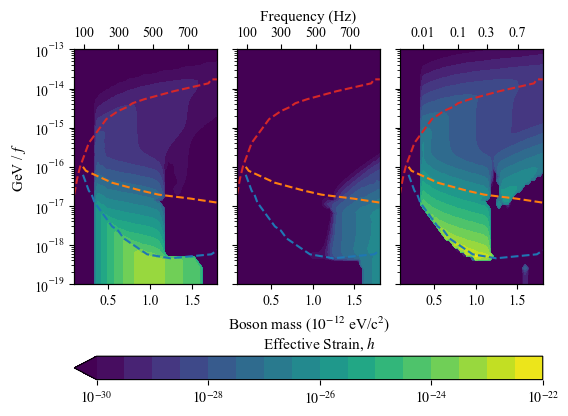

In [19]:
#my_ticks = [1e-40,1e-38,1e-36,1e-34,1e-32,1e-30,1e-28,1e-26,1e-24,1e-22]
#my_tick_labels = [r"$<10^{-40}$","$10^{-38}$","$10^{-36}$","$10^{-34}$","$10^{-32}$","$10^{-30}$",
#                  "$10^{-28}$","$10^{-26}$","$10^{-24}$","$10^{-22}$"]
my_ticks = [1e-30,1e-28,1e-26,1e-24,1e-22]
my_tick_labels = [r"$10^{-30}$","$10^{-28}$","$10^{-26}$","$10^{-24}$","$10^{-22}$"]


# Define alpha ticks
new_tick_alphas = np.array([0.05,0.10,0.15],dtype=float)
new_tick_locations = func.invert_alpha_bm(new_tick_alphas,bhmf_goal)
# Define frequency ticks
tick_nu_211_an = np.array([100,300,500,700],dtype=float)
tick_nu_211_an_loc = np.zeros_like(tick_nu_211_an)
for i in range(len(tick_nu_211_an)):
    tick_nu_211_an_loc[i] = interpolate(nu_211_an_V[0],bm_V[0],tick_nu_211_an[i])
tick_nu_322_an = np.array([100,300,500,700],dtype=float)
tick_nu_322_an_loc = np.zeros_like(tick_nu_322_an)
for i in range(len(tick_nu_322_an)):
    tick_nu_322_an_loc[i] = interpolate(nu_322_an_V[0],bm_V[0],tick_nu_322_an[i])
tick_nu_tr = np.array([1e-2,1e-1,3e-1,7e-1])
tick_nu_tr_loc = np.zeros_like(tick_nu_tr)
for i in range(len(tick_nu_tr)):
    tick_nu_tr_loc[i] = interpolate(nu_tr_V[0],bm_V[0],tick_nu_tr[i])

# Plot results with log scales
# Define ranges of log scales:
min_bound = -30
max_bound = -22
num_scale = 2
h_211_211_an_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
h_322_322_an_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
h_322_to_211_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)

# Clean data of values outside of this range
h_211_211_an_c_V = np.copy(h_211_211_an_V)
h_322_322_an_c_V = np.copy(h_322_322_an_V)
h_322_to_211_c_V = np.copy(h_322_to_211_V)
for i in range(len(h_211_211_an_c_V)):
    for j in range(len(h_211_211_an_c_V[i])):
        if h_211_211_an_c_V[i][j]<10**min_bound:
            h_211_211_an_c_V[i][j]=10**min_bound
        if h_322_322_an_c_V[i][j]<10**min_bound:
            h_322_322_an_c_V[i][j]=10**min_bound
        if h_322_to_211_c_V[i][j]<10**min_bound:
            h_322_to_211_c_V[i][j]=10**min_bound

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(6*(13.6/14.5),4.8),sharey=True)

ax1.set_yscale("log")
ax1.set_ylim(1e-19,1e-13)
#ax1.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
ax1.set_ylabel("GeV / $f$",fontsize=11)
plot1 = ax1.contourf(bm_V*1e12,1/f_V,h_211_211_an_c_V*h_factor_211,h_211_211_an_crange,norm=LogNorm(),extend="min")
ax1.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax1.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax1.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax1.plot(bm_vals*1e12,f_AB_vals,label="A-B",linestyle="--",color="C0")
#ax1.plot(bm_vals*1e12,f_BC_vals,label="B-C",linestyle="--",color="C1")
#ax1.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--",color="C3")
#ax1.set_title(r"$211\times 211$ Annihilation",fontsize = 12)

ax2.set_yscale("log")
ax2.set_ylim(1e-19,1e-13)
ax2.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
#ax2.set_ylabel("Interaction Parameter, f (GeV)",fontsize=11)
plot2 = ax2.contourf(bm_V*1e12,1/f_V,h_322_322_an_c_V*h_factor_322,h_322_322_an_crange,norm=LogNorm(),extend="min")
ax2.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax2.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax2.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax2.plot(bm_vals*1e12,f_AB_vals,label="A-B",linestyle="--",color="C0")
#ax2.plot(bm_vals*1e12,f_BC_vals,label="B-C",linestyle="--",color="C1")
#ax2.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--",color="C3")
#ax2.set_title(r"$322\times 322$ Annihilation",fontsize = 12)

ax3.set_yscale("log")
ax3.set_ylim(1e-19,1e-13)
#ax3.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
#ax3.set_ylabel("Interaction Parameter, f (GeV)",fontsize=11)
plot3 = ax3.contourf(bm_V*1e12,1/f_V,h_322_to_211_c_V*h_factor_tr,h_322_to_211_crange,norm=LogNorm(),extend="min")
ax3.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax3.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax3.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax3.plot(bm_vals*1e12,f_AB_vals,label="A-B",linestyle="--",color="C0")
#ax3.plot(bm_vals*1e12,f_BC_vals,label="B-C",linestyle="--",color="C1")
#ax3.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--",color="C3")
#ax3.set_title(r"$322\rightarrow 211$ Transiton",fontsize = 12)

# Set alpha ticks
ax4 = ax1.twiny()
ax5 = ax2.twiny()
ax6 = ax3.twiny()
ax4.set_xlim(ax1.get_xlim())
ax5.set_xlim(ax2.get_xlim())
ax6.set_xlim(ax3.get_xlim())
ax4.set_xticks(tick_nu_211_an_loc*1e12)
ax5.set_xticks(tick_nu_322_an_loc*1e12)
ax6.set_xticks(tick_nu_tr_loc*1e12)
ax4.set_xticklabels(['100','300','500','700'])
ax5.set_xticklabels(['100','300','500','700'])
ax6.set_xticklabels(tick_nu_tr)
#ax4.set_xlabel(r"Frequency (Hz)", fontsize=11)
ax5.set_xlabel(r"Frequency (Hz)", fontsize=11)
#ax6.set_xlabel(r"Frequency (Hz)", fontsize=11)

plt.tight_layout()

# Color bar
cbar = fig.colorbar(plot1,ax=[ax1,ax2,ax3],location="bottom",pad=0.2,ticks=my_ticks)
cbar.ax.set_xticklabels(my_tick_labels)
cbar.ax.set_title(r"Effective Strain, $h$", fontsize=11)

# Show results
#plt.savefig("NRCygnus1e5GW.pdf",bbox_inches="tight")
plt.show()

#### Drift

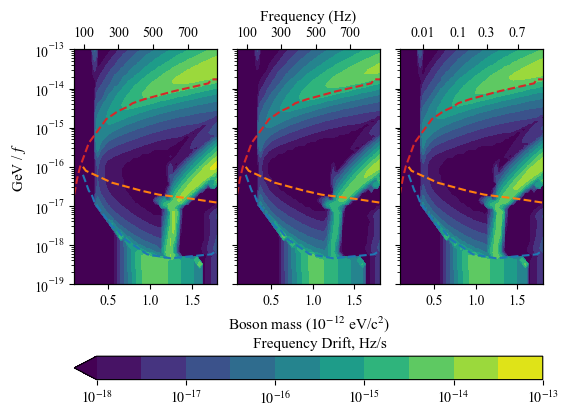

In [20]:
#my_ticks = [1e-28,1e-26,1e-24,1e-22,1e-20,1e-18,1e-16,1e-14,1e-12]
#my_tick_labels = [r"$10^{-28}$","$10^{-26}$","$10^{-24}$","$10^{-22}$","$10^{-20}$","$10^{-18}$","$10^{-16}$","$10^{-14}$","$10^{-12}$"]

my_ticks = [1e-18,1e-17,1e-16,1e-15,1e-14,1e-13,1e-12]#1e-24,1e-22,1e-20,
my_tick_labels = ["$10^{-18}$","$10^{-17}$","$10^{-16}$","$10^{-15}$","$10^{-14}$","$10^{-13}$","$10^{-12}$"]

# Define alpha ticks
new_tick_alphas = np.array([0.05,0.10,0.15],dtype=float)
new_tick_locations = func.invert_alpha_bm(new_tick_alphas,bhmf_goal)
# Define frequency ticks
tick_nu_211_an = np.array([100,300,500,700],dtype=float)
tick_nu_211_an_loc = np.zeros_like(tick_nu_211_an)
for i in range(len(tick_nu_211_an)):
    tick_nu_211_an_loc[i] = interpolate(nu_211_an_V[0],bm_V[0],tick_nu_211_an[i])
tick_nu_322_an = np.array([100,300,500,700],dtype=float)
tick_nu_322_an_loc = np.zeros_like(tick_nu_322_an)
for i in range(len(tick_nu_322_an)):
    tick_nu_322_an_loc[i] = interpolate(nu_322_an_V[0],bm_V[0],tick_nu_322_an[i])
tick_nu_tr = np.array([1e-2,1e-1,3e-1,7e-1])
tick_nu_tr_loc = np.zeros_like(tick_nu_tr)
for i in range(len(tick_nu_tr)):
    tick_nu_tr_loc[i] = interpolate(nu_tr_V[0],bm_V[0],tick_nu_tr[i])

# Define ranges of log scales:
min_bound = -18 #24
max_bound = -13
num_scale = 2
drift_211_211_an_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
drift_322_322_an_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
drift_322_to_211_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)

# Clean data of values outside of this range
drift_211_211_an_c_V = np.copy(drift_211_211_an_V)
drift_322_322_an_c_V = np.copy(drift_322_322_an_V)
drift_322_to_211_c_V = np.copy(drift_322_to_211_V)

for i in range(len(drift_211_211_an_c_V)):
    for j in range(len(drift_211_211_an_c_V[i])):
        if np.abs(drift_211_211_an_c_V[i][j])<10**min_bound:
            drift_211_211_an_c_V[i][j]=0.1*10**min_bound
        if np.abs(drift_322_322_an_c_V[i][j])<10**min_bound:
            drift_322_322_an_c_V[i][j]=0.1*10**min_bound
        if np.abs(drift_322_to_211_c_V[i][j])<10**min_bound:
            drift_322_to_211_c_V[i][j]=0.1*10**min_bound
            
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(6*(13.6/14.5),4.8),sharey=True)

ax1.set_yscale("log")
ax1.set_ylim(1e-19,1e-13)
#ax1.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
ax1.set_ylabel("GeV / $f$",fontsize=11)
plot1 = ax1.contourf(bm_V*1e12,1/f_V,np.abs(drift_211_211_an_c_V),drift_211_211_an_crange,norm=LogNorm(),extend="min")
ax1.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax1.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax1.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax1.plot(bm_vals*1e12,f_AB_vals,label="A-B",linestyle="--",color="C0")
#ax1.plot(bm_vals*1e12,f_BC_vals,label="B-C",linestyle="--",color="C1")
#ax1.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--",color="C3")
#ax1.set_title(r"$211\times 211$ Annihilation",fontsize = 12)

ax2.set_yscale("log")
ax2.set_ylim(1e-19,1e-13)
ax2.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
#ax2.set_ylabel("Interaction Parameter, f (GeV)",fontsize=11)
plot2 = ax2.contourf(bm_V*1e12,1/f_V,np.abs(drift_322_322_an_c_V),drift_322_322_an_crange,norm=LogNorm(),extend="min")
ax2.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax2.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax2.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax2.plot(bm_vals*1e12,f_AB_vals,label="A-B",linestyle="--",color="C0")
#ax2.plot(bm_vals*1e12,f_BC_vals,label="B-C",linestyle="--",color="C1")
#ax2.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--",color="C3")
#ax2.set_title(r"$322\times 322$ Annihilation",fontsize = 12)

ax3.set_yscale("log")
ax3.set_ylim(1e-19,1e-13)
#ax3.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
#ax3.set_ylabel("Interaction Parameter, f (GeV)",fontsize=11)
plot3 = ax3.contourf(bm_V*1e12,1/f_V,np.abs(drift_322_to_211_c_V),drift_322_to_211_crange,norm=LogNorm(),extend="min")
ax3.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax3.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax3.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax3.plot(bm_vals*1e12,f_AB_vals,label="A-B",linestyle="--",color="C0")
#ax3.plot(bm_vals*1e12,f_BC_vals,label="B-C",linestyle="--",color="C1")
#ax3.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--",color="C3")
#ax3.set_title(r"$322\rightarrow 211$ Transiton",fontsize = 12)

# Set alpha ticks
ax4 = ax1.twiny()
ax5 = ax2.twiny()
ax6 = ax3.twiny()
ax4.set_xlim(ax1.get_xlim())
ax5.set_xlim(ax2.get_xlim())
ax6.set_xlim(ax3.get_xlim())
ax4.set_xticks(tick_nu_211_an_loc*1e12)
ax5.set_xticks(tick_nu_322_an_loc*1e12)
ax6.set_xticks(tick_nu_tr_loc*1e12)
ax4.set_xticklabels(['100','300','500','700'])
ax5.set_xticklabels(['100','300','500','700'])
ax6.set_xticklabels(tick_nu_tr)
#ax4.set_xlabel(r"Frequency (Hz)", fontsize=11)
ax5.set_xlabel(r"Frequency (Hz)", fontsize=11)
#ax6.set_xlabel(r"Frequency (Hz)", fontsize=11)

plt.tight_layout()

# Color bar
cbar = fig.colorbar(plot1,ax=[ax1,ax2,ax3],location="bottom",pad=0.2,ticks=my_ticks)
cbar.ax.set_xticklabels(my_tick_labels)
cbar.ax.set_title(r"Frequency Drift, Hz/s", fontsize=11)

# Scatter pins
pins = False
if pins:
    i, j = 32, 48
    ax1.scatter(bm_V[i,j]/1e-12,1/f_V[i,j],s=20, color = "red")
    ax2.scatter(bm_V[i,j]/1e-12,1/f_V[i,j],s=20, color = "red")
    ax3.scatter(bm_V[i,j]/1e-12,1/f_V[i,j],s=20, color = "red")

# Show results
#plt.savefig("DriftCygnus1e5GW.pdf",bbox_inches="tight")
plt.show()

### Zoomed in probed region

In [21]:
# Determine measured frequencies
measured_freqs = []
file = open("211bounds.txt","r")
for i, row in enumerate(file):
    if i != 0:
        vals = row.rsplit()
        measured_freqs.append(float(vals[0]))
print(len(measured_freqs))

418


In [22]:
# Convert h-factor back to form for comparison
# Report results (rel. to h for face-on 211 annihilation signal)
print(h_factor_211)
print(h_factor_322)
print(h_factor_tr)

# Correct for definition from 211 annihilation at iota
h_factor_322 = h_factor_322/h_factor_211
h_factor_tr = h_factor_tr/h_factor_211
h_factor_211 = h_factor_211/h_factor_211

# Report results (For use)
print(h_factor_211)
print(h_factor_322)
print(h_factor_tr)

0.8932311943750108
0.32895530246157423
0.4312381847610747
1.0
0.36827565420142155
0.48278451030005715


In [23]:
# Set bounds of region
zoom_f_min = 1e16
zoom_f_max = 1e19
freq_min = bm_V[0,0]*2*func.e/func.h
freq_max = bm_V[0,-1]*2*func.e/func.h
# Find matching indexes
zoom_bm_index_min = 0
zoom_f_index_min = find_match_index(zoom_f_min,f_V[:,0])
# Select region of special interest
bm_subset_V = bm_V[zoom_f_index_min:,zoom_bm_index_min:]
f_subset_V = f_V[zoom_f_index_min:,zoom_bm_index_min:]
h_211_211_an_c_subset_V = h_211_211_an_c_V[zoom_f_index_min:,zoom_bm_index_min:]
h_322_322_an_c_subset_V = h_322_322_an_c_V[zoom_f_index_min:,zoom_bm_index_min:]
h_322_to_211_c_subset_V = h_322_to_211_c_V[zoom_f_index_min:,zoom_bm_index_min:]
# Generate regular grid interpolator for subspace
interp_211 = RegularGridInterpolator((f_subset_V[:,0],bm_subset_V[0,:]),h_211_211_an_c_subset_V[:,:])
interp_322 = RegularGridInterpolator((f_subset_V[:,0],bm_subset_V[0,:]),h_322_322_an_c_subset_V[:,:])
interp_tr = RegularGridInterpolator((f_subset_V[:,0],bm_subset_V[0,:]),h_322_to_211_c_subset_V[:,:])

# Generate grid with required resolution
num_bm = int((freq_max - freq_min)+1)*2
num_f = len(f_subset_V[0,:])*5
bm_subset_vals = np.linspace(min(bm_subset_V[0]),max(bm_subset_V[0]),num=num_bm)
f_subset_vals = np.logspace(np.log10(min(f_subset_V[:,0])),np.log10(max(f_subset_V[:,0])),num=num_f)
bm_subset_V, f_subset_V = np.meshgrid(bm_subset_vals,f_subset_vals)
h_211_211_an_subset_V = np.zeros_like(bm_subset_V)
h_322_322_an_subset_V = np.zeros_like(bm_subset_V)
h_322_to_211_subset_V = np.zeros_like(bm_subset_V)
for i in range(len(bm_subset_V)):
    for j in range(len(bm_subset_V[i])):
        h_211_211_an_subset_V[i,j] = interp_211((f_subset_V[i][j],bm_subset_V[i][j]))
        h_322_322_an_subset_V[i,j] = interp_322((f_subset_V[i][j],bm_subset_V[i][j]))
        h_322_to_211_subset_V[i,j] = interp_tr((f_subset_V[i][j],bm_subset_V[i][j]))

# To try:
#h_211_211_an_subset_V = interp_211((f_subset_V,bm_subset_V))
#h_322_322_an_subset_V = interp_322((f_subset_V,bm_subset_V))
#h_322_to_211_an_subset_V = interp_322_to_211((f_subset_V,bm_subset_V))

# Now generate rejection contour
# Define array to determine bound computation
h_211_fail_V = np.zeros_like(h_211_211_an_subset_V)

h_211_fail_dict = {"aligo_design":np.zeros_like(h_211_211_an_subset_V),"ce2":np.zeros_like(h_211_211_an_subset_V),
                   "et_d":np.zeros_like(h_211_211_an_subset_V),"magiss-r":np.zeros_like(h_211_211_an_subset_V),
                   "decigo":np.zeros_like(h_211_211_an_subset_V)}
h_322_fail_dict ={"aligo_design":np.zeros_like(h_211_211_an_subset_V),"ce2":np.zeros_like(h_211_211_an_subset_V),
                   "et_d":np.zeros_like(h_211_211_an_subset_V),"magiss-r":np.zeros_like(h_211_211_an_subset_V),
                   "decigo":np.zeros_like(h_211_211_an_subset_V)}
h_tr_fail_dict = {"aligo_design":np.zeros_like(h_211_211_an_subset_V),"ce2":np.zeros_like(h_211_211_an_subset_V),
                   "et_d":np.zeros_like(h_211_211_an_subset_V),"magiss-r":np.zeros_like(h_211_211_an_subset_V),
                   "decigo":np.zeros_like(h_211_211_an_subset_V)}


# Define curves to find prospective sensitivity
curves_of_interest = ["aligo_design","ce2","et_d","decigo","magiss-r"]


count = 0
# Compute strains
for i in range(len(h_211_211_an_subset_V)):
    for j in range(len(h_211_211_an_subset_V[i])):
            # Pull values
            bm = bm_subset_V[i][j]
            bhm = 14.8
            # Compute alpha
            alpha = func.compute_alpha(bm, bhm)
            # Compute energies
            E_211_211_an = 2*func.compute_energy(bm, bhm, 2)
            E_322_322_an = 2*func.compute_energy(bm, bhm, 3)
            E_322_to_211 = func.compute_energy(bm, bhm, 3) - func.compute_energy(bm, bhm, 2)
            # Compare characterstic strains to bounds
            nu_211_211_an = E_211_211_an/h
            nu_211_211_an = float(nu_211_211_an//1+0.5)

            nu_322_322_an = E_322_322_an/h
            nu_322_to_211 = E_322_to_211/h

            if nu_211_211_an in measured_freqs:
                count+=1
                if interpolate(sens_dict["o2_real"][0], h0_211_bounds_dict["o2_real"], nu_211_211_an) <= h_factor_211*h_211_211_an_subset_V[i,j]:
                    h_211_fail_V[i][j] = 1
            for curve in curves_of_interest:
                if interpolate(sens_dict[curve][0], h0_211_bounds_dict[curve], nu_211_211_an) <= h_factor_211*h_211_211_an_subset_V[i][j]:
                    h_211_fail_dict[curve][i][j] = 1
                if interpolate(sens_dict[curve][0], h0_211_bounds_dict[curve], nu_322_322_an) <= h_factor_322* h_322_322_an_subset_V[i][j]:
                    h_322_fail_dict[curve][i][j] = 1
                if interpolate(sens_dict[curve][0], h0_211_bounds_dict[curve], nu_322_to_211) <= h_factor_tr*h_322_to_211_subset_V[i][j]:
                    h_tr_fail_dict[curve][i][j] = 1

In [24]:
# Generate minimum f values list for shading the excluded region
# Define max f to be used in case of failure of detection (this is a plotting thing without physical significance)
# Simply put, a big number must be chosen
max_f = 1e25
min_f_list = []
for i in range(len(f_subset_V[0])):
    val = max_f
    for j in range(len(f_subset_V)):
        if h_211_fail_V[-j,i] == 1:
            val = f_subset_V[-j,i]
    min_f_list.append(val)

In [25]:
min_f_list = np.array(min_f_list, dtype="float")

In [26]:
# Compute angular distribution correction factor

# For 211
def ang_211_power(N_211,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = 9*func.G*func.hbar**2/(2**26*func.c)
    scale = N_211**2*alpha**18/r_g**4
    angular_dependence = (35+28*np.cos(2*theta)+np.cos(4*theta))
    return const*scale*angular_dependence
# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
# Compute max vs. integral
ang_211_template = ang_211_power(1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_211_template)
max_v_auc_211 = max(ang_211_template)/auc
h_factor_211 = ((ang_211_power(1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

# For 322
Mc = 1.0
Mbh = 14.8
abh = 0.5
_m = 2
mu_fac = 7.48548859e9
_mu = 1e-13*mu_fac # eV by factor
d_fac = 4.78691895e-20
_d = 2.25e-3*d_fac
_cloud_model = sr.rel_sca_cloud.RelScalar()

thetaObs_array = np.linspace(0,1*np.pi,num=101)
hp_array = np.zeros_like(thetaObs_array)
hx_array = np.zeros_like(thetaObs_array)

for i, thetaObs in enumerate(thetaObs_array):
    strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
    hl = strain_vec(_m, _mu*Mbh, abh)
    
    hp = 0.0
    hx = 0.0
    l = 2*_m 
    for hl0 in hl:
        Yp = har.sYlm(-2,l,2*_m,thetaObs)
        Ym = har.sYlm(-2,l,-2*_m,thetaObs)
        hp = hp + hl0*(Yp+(-1)**l*Ym)
        hx = hx + hl0*(Yp-(-1)**l*Ym)
        l = l + 1
    delta = np.angle(hx)-np.angle(hp)
    #Make delta in [-pi,pi)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi
    hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
    hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)
    
    hp_array[i] = hp
    hx_array[i] = hx

auc = np.trapz(np.sin(thetaObs_array)*(hp_array**2+hx_array**2))

strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
hl = strain_vec(_m, _mu*Mbh, abh)

hp = 0.0
hx = 0.0
l = 2*_m 
for hl0 in hl:
    Yp = har.sYlm(-2,l,2*_m,iota)
    Ym = har.sYlm(-2,l,-2*_m,iota)
    hp = hp + hl0*(Yp+(-1)**l*Ym)
    hx = hx + hl0*(Yp-(-1)**l*Ym)
    l = l + 1
hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)
    
h_factor_322 = (((hp**2+hx**2)/auc)/max_v_auc_211)**0.5

# For transition
def ang_transition_power(N_211,N_322,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = func.G*func.hbar**2/(np.pi*func.c)
    scale = N_322*N_211*alpha**14/r_g**4
    angular_dependence = 2**5/(3**6*5**8)*(1-np.cos(theta)**4)+((27+28*np.cos(2*theta)+9*np.cos(4*theta))*np.sin(theta)**2)/\
    (2**2*3**6*5**10*7**2)
    return const*scale*angular_dependence

# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
ang_transition_template = ang_transition_power(1e76,1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_transition_template)
# Compute h factor function
h_factor_tr = ((ang_transition_power(1e76,1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

# Report results (rel. to h for face-on 211 annihilation signal)
print(h_factor_211)
print(h_factor_322)
print(h_factor_tr)

0.8932311943750108
0.32895530246157423
0.4312381847610747


In [27]:
conf.line_dic['et_d']=['black', (0, (3, 1, 1, 1))]
# Define frequency ticks
tick_nu_211_an = np.array([100,300,500,700],dtype=float)
tick_nu_211_an_loc = np.zeros_like(tick_nu_211_an)
for i in range(len(tick_nu_211_an)):
    tick_nu_211_an_loc[i] = interpolate(nu_211_an_V[0],bm_V[0],tick_nu_211_an[i])
tick_nu_322_an = np.array([100,300,500,700],dtype=float)
tick_nu_322_an_loc = np.zeros_like(tick_nu_322_an)
for i in range(len(tick_nu_322_an)):
    tick_nu_322_an_loc[i] = interpolate(nu_322_an_V[0],bm_V[0],tick_nu_322_an[i])
tick_nu_tr = np.array([1e-2,1e-1,3e-1,7e-1])
tick_nu_tr_loc = np.zeros_like(tick_nu_tr)
for i in range(len(tick_nu_tr)):
    tick_nu_tr_loc[i] = interpolate(nu_tr_V[0],bm_V[0],tick_nu_tr[i])

C:\Users\LocalUser\AppData\Local\Temp\ipykernel_16936\2888331738.py:32: UserWarning: No contour levels were found within the data range.
  ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict["aligo_design"],0,alpha=1, colors=conf.line_dic["aligo_design"][0],linewidths=lw)
C:\Users\LocalUser\AppData\Local\Temp\ipykernel_16936\2888331738.py:33: UserWarning: No contour levels were found within the data range.
  ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict["et_d"],0,alpha=1, colors=conf.line_dic["et_d"][0],linewidths=lw)
C:\Users\LocalUser\AppData\Local\Temp\ipykernel_16936\2888331738.py:34: UserWarning: No contour levels were found within the data range.
  ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict["ce2"],0,alpha=1, colors=conf.line_dic["ce2"][0],linewidths=lw)
C:\Users\LocalUser\AppData\Local\Temp\ipykernel_16936\2888331738.py:35: UserWarning: No contour levels were found within the data range.
  ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict[

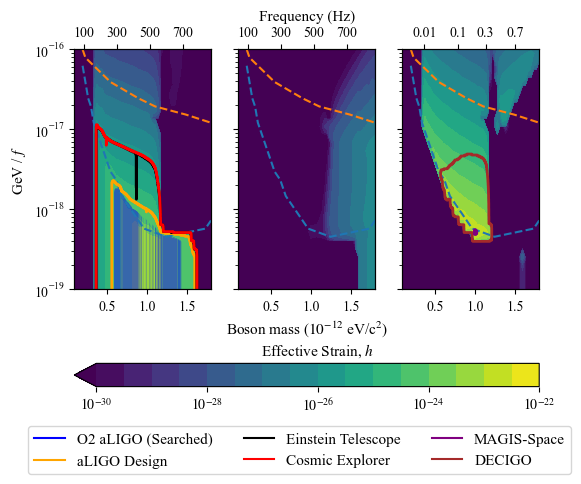

In [28]:
# Define ranges of log scales:
min_bound = -30
max_bound = -22
num_scale = 2
h_211_211_an_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
h_322_322_an_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
h_322_to_211_crange = np.logspace(min_bound,max_bound,num=(max_bound-min_bound)*num_scale+1)
#my_ticks = [1e-40,1e-38,1e-36,1e-34,1e-32,1e-30,1e-28,1e-26,1e-24,1e-22]
#my_tick_labels = [r"$<10^{-40}$","$10^{-38}$","$10^{-36}$","$10^{-34}$","$10^{-32}$","$10^{-30}$",
#                  "$10^{-28}$","$10^{-26}$","$10^{-24}$","$10^{-22}$"]

my_ticks = [1e-30,1e-28,1e-26,1e-24,1e-22]
my_tick_labels = [r"$10^{-30}$","$10^{-28}$","$10^{-26}$","$10^{-24}$","$10^{-22}$"]


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(6,4.8),sharey=True)

lw = 2.0

ax1.set_yscale("log")
#ax1.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
ax1.set_ylabel("GeV / $f$",fontsize=11)
plot1 = ax1.contourf(bm_V*1e12,1/f_V,h_211_211_an_c_V*h_factor_211,h_211_211_an_crange,norm=LogNorm(),extend="min")
ax1.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax1.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
#ax1.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax1.plot(bm_vals*1e12,f_AB_vals,linestyle="--")
#ax1.plot(bm_vals*1e12,f_BC_vals,label="B-C",linestyle="--")
#ax1.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--")
ax1.fill_between((bm_subset_V*1e12)[0],1/min_f_list,1/max_f,alpha=0.5, color=conf.line_dic["o2_real"][0],edgecolor=None)
#ax1.contour(bm_subset_V*1e12,f_subset_V,h_211_fail_V,0,alpha=1, colors=conf.line_dic["o2_real"][0],linewidths=lw)
ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict["aligo_design"],0,alpha=1, colors=conf.line_dic["aligo_design"][0],linewidths=lw)
ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict["et_d"],0,alpha=1, colors=conf.line_dic["et_d"][0],linewidths=lw)
ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict["ce2"],0,alpha=1, colors=conf.line_dic["ce2"][0],linewidths=lw)
ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict["decigo"],0,alpha=1, colors=conf.line_dic["decigo"][0],linewidths=lw)
ax1.contour(bm_subset_V*1e12,1/f_subset_V,h_211_fail_dict["magiss-r"],0,alpha=1, colors=conf.line_dic["magiss-r"][0],linewidths=lw)
#ax1.set_title(r"$211\times 211$ Annihilation",fontsize = 12)

ax2.set_yscale("log")
ax2.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
#ax2.set_ylabel("GeV / $f$",fontsize=11)
plot2 = ax2.contourf(bm_V*1e12,1/f_V,h_322_322_an_c_V*h_factor_322,h_211_211_an_crange,norm=LogNorm(),extend="min")
ax2.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax2.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
#ax2.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax1.plot(bm_vals*1e12,f_AB_vals,linestyle="--")
#ax1.plot(bm_vals*1e12,f_BC_vals,label="B-C",linestyle="--")
#ax1.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--")
#ax2.fill_between((bm_subset_V*1e12)[0],1/min_f_list,1/max_f,alpha=0.5, color=conf.line_dic["o2_real"][0],edgecolor=None)
#ax1.contour(bm_subset_V*1e12,f_subset_V,h_211_fail_V,0,alpha=1, colors=conf.line_dic["o2_real"][0],linewidths=lw)
ax2.contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict["aligo_design"],0,alpha=1, colors=conf.line_dic["aligo_design"][0],linewidths=lw)
ax2.contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict["et_d"],0,alpha=1, colors=conf.line_dic["et_d"][0],linewidths=lw)
ax2.contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict["ce2"],0,alpha=1, colors=conf.line_dic["ce2"][0],linewidths=lw)
ax2.contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict["decigo"],0,alpha=1, colors=conf.line_dic["decigo"][0],linewidths=lw)
ax2.contour(bm_subset_V*1e12,1/f_subset_V,h_322_fail_dict["magiss-r"],0,alpha=1, colors=conf.line_dic["magiss-r"][0],linewidths=lw)
#ax1.set_title(r"$211\times 211$ Annihilation",fontsize = 12)

ax3.set_yscale("log")
#ax3.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)",fontsize=11)
#ax3.set_ylabel("Interaction Parameter, f (GeV)",fontsize=11)
plot3 = ax3.contourf(bm_V*1e12,1/f_V,h_322_to_211_c_V*h_factor_tr,h_322_to_211_crange,norm=LogNorm(),extend="min")

ax3.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax3.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
#ax3.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
#ax3.plot(bm_vals*1e12,f_AB_vals,linestyle="--")
#ax3.plot(bm_vals*1e12,f_BC_vals,linestyle="--")
#ax3.plot(bm_vals*1e12,f_CD_vals,label="C-D",linestyle="--")
ax3.contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict["aligo_design"],0,alpha=1, colors=conf.line_dic["aligo_design"][0],linewidths=lw)
ax3.contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict["et_d"],0,alpha=1, colors=conf.line_dic["et_d"][0],linewidths=lw)
ax3.contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict["ce2"],0,alpha=1, colors=conf.line_dic["ce2"][0],linewidths=lw)
ax3.contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict["decigo"],0,alpha=1, colors=conf.line_dic["decigo"][0],linewidths=lw)
ax3.contour(bm_subset_V*1e12,1/f_subset_V,h_tr_fail_dict["magiss-r"],0,alpha=1, colors=conf.line_dic["magiss-r"][0],linewidths=lw)
#ax3.set_title(r"$322\rightarrow 211$ Transiton",fontsize = 12)

ax1.set_ylim(1/zoom_f_max,1/zoom_f_min)
ax2.set_ylim(1/zoom_f_max,1/zoom_f_min)
ax3.set_ylim(1/zoom_f_max,1/zoom_f_min)

ax1.set_xlim(bm_subset_V[0,0]*1e12,bm_subset_V[0,-1]*1e12)
ax2.set_xlim(bm_subset_V[0,0]*1e12,bm_subset_V[0,-1]*1e12)
ax3.set_xlim(bm_subset_V[0,0]*1e12,bm_subset_V[0,-1]*1e12)

# Set frequency ticks
ax4 = ax1.twiny()
ax5 = ax2.twiny()
ax6 = ax3.twiny()
ax4.set_xlim(ax1.get_xlim())
ax5.set_xlim(ax2.get_xlim())
ax6.set_xlim(ax3.get_xlim())
ax4.set_xticks(tick_nu_211_an_loc*1e12)
ax5.set_xticks(tick_nu_322_an_loc*1e12)
ax6.set_xticks(tick_nu_tr_loc*1e12)
ax4.set_xticklabels(['100','300','500','700'])
ax5.set_xticklabels(['100','300','500','700'])
ax6.set_xticklabels(tick_nu_tr)
#ax4.set_xlabel(r"Frequency (Hz)", fontsize=11)
ax5.set_xlabel(r"Frequency (Hz)", fontsize=11)
#ax6.set_xlabel(r"Frequency (Hz)", fontsize=11)

# Colorbar
cbar = fig.colorbar(plot1,ax=[ax1,ax2,ax3],location="bottom",pad=0.2,ticks=my_ticks)
cbar.ax.set_xticklabels(my_tick_labels)
#cbar.ax.set_title(r"Characteristic Strain, $h_0$", fontsize=11)
cbar.ax.set_title(r"Effective Strain, $h$", fontsize=11)

# Legend
line0 = Line2D([0],[0],label="O2 aLIGO (Searched)", color = conf.line_dic["o2_real"][0])
line1 = Line2D([0],[0],label="aLIGO Design", color = conf.line_dic["aligo_design"][0])
line2 = Line2D([0],[0],label="Einstein Telescope", color = conf.line_dic["et_d"][0])
line3 = Line2D([0],[0],label="Cosmic Explorer", color = conf.line_dic["ce2"][0])
line4 = Line2D([0],[0],label="MAGIS-Space", color = conf.line_dic["magiss-r"][0])
line5 = Line2D([0],[0],label="DECIGO", color = conf.line_dic["decigo"][0])
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line0,line1,line2,line3,line4,line5])
ax1.legend(handles=handles, loc = "lower center",fontsize=11,bbox_to_anchor = [1.65,-0.8],ncol=3)

#plt.savefig("V2NR1e5ZoomGWV2.pdf",bbox_inches="tight")
plt.show()

### Generate Corrected Initial Masses
(Only holds if data complete)

In [29]:
# First let's define what we want to write out
f_vals = f_V[:,0]
bm_vals = bm_V[0]
bhmi_G = bhmi_V-(bhm_V-bhmf_goal)

# Now, let's write out the constructed interpolator to a file
filename="bhmi_guess.txt"
file = open(filename,"w")
# Write out bm values
file.write("bm\n")
line = ""
for bm in bm_vals:
    line += str(bm) + " "
line += "\n"
file.write(line)
# Write out f vals
file.write("f\n")
for f in f_vals:
    file.write(str(f)+"\n")
# Write out bhmi vals
file.write("bhmi\n")
for i in range(len(f_vals)):
    line = ""
    for j in range(len(bm_vals)):
        line += str(bhmi_G[i][j]) + " "
    line += "\n"
    file.write(line)
file.close()

# Now let's try reading it back in
filename="bhmi_guess.txt"
file = open(filename,"r")
# Read first line
file.readline()
# Now let's get our bm values
line = file.readline()
bm_vals = line.rsplit()
bm_vals = np.array(bm_vals,dtype=np.float64)
# Read third line
file.readline()
# Now let's get our f values
f_vals = []
reading = True
while reading:
    line = file.readline()
    if line[0]!="b":
        f_vals.append(line.rstrip())
    else:
        reading = False
f_vals = np.array(f_vals,dtype=np.float64)
# Now let's acquire our bhmi values
# Define grid to store values
bm_G, f_G = np.meshgrid(bm_vals, f_vals)
bhmi_G = np.zeros_like(bm_G)
# Note: header line is already skipped
# Read in remaining lines
lines = file.readlines()
for i, line in enumerate(lines):
    vals = line.rsplit()
    for j, val in enumerate(vals):
        bhmi_G[i][j] = val
file.close()

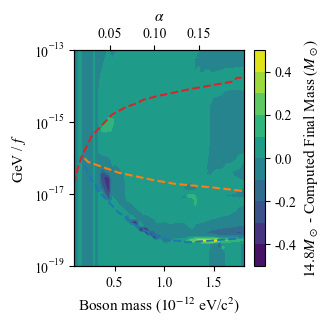

In [30]:
# Define colorbar ticks
my_ticks = [-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6]
my_tick_labels = [r"-0.6","-0.4","-0.2","0.0","0.2","0.4","$0.6$"]

# Define alpha ticks
new_tick_alphas = np.array([0.05,0.10,0.15])
new_tick_locations = func.invert_alpha_bm(new_tick_alphas,bhmf_goal)

fig, ax1 = plt.subplots(1,1,figsize=[3.35,3.35])#[6.7,6.7])
crange = np.linspace(-0.5,0.5,num=11)
plot1=ax1.contourf(bm_V*1e12,1/f_V,14.8-bhm_V,crange)
ax1.plot(bm_grav_mod_list*1e12,1/grav_mod_list,linestyle="--",color="C0")
ax1.plot(bm_mod_strong_list*1e12,1/mod_strong_list,linestyle="--",color="C1")
ax1.plot(bm_strong_very_strong_list*1e12,1/strong_very_strong_list,linestyle="--",color="C3")
ax1.set_yscale("log")
ax1.set_xlabel("Boson mass ($10^{-12}$ eV/c$^2$)", fontsize=11)
ax1.set_ylabel("GeV / $f$", fontsize=11)
cbar = fig.colorbar(plot1,ax=ax1,ticks=my_ticks)
cbar.ax.set_yticklabels(my_tick_labels)
cbar.set_label(r"$14.8M_\odot$ - Computed Final Mass ($M_\odot$)", fontsize=11)

# Set alpha ticks
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations*1e12)
ax2.set_xticklabels(tick_function(new_tick_alphas))
ax2.set_xlabel(r"$\alpha$", fontsize=11)
plt.tight_layout()

plt.savefig("NRResidual1e5.pdf",bbox_inches = "tight")
plt.show()

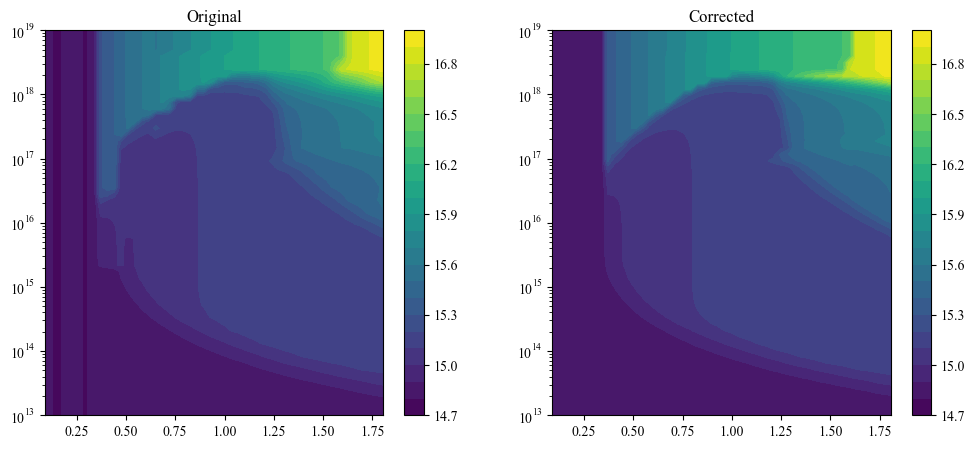

In [31]:
# Generate comparison plots
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[12,5])
crange = np.linspace(14.7,17.0,num=24)
#crange = np.linspace(0,16.8,num=9)
plot1=ax1.contourf(bm_V*1e12,f_V,bhmi_V,crange)
ax1.set_yscale("log")
ax1.set_title("Original")
cbar = fig.colorbar(plot1,ax=ax1)
plot2 = ax2.contourf(bm_V*1e12,f_V,bhmi_G,crange)
ax2.set_yscale("log")
ax2.set_title("Corrected")
cbar = fig.colorbar(plot2,ax=ax2)